<a href="https://colab.research.google.com/github/viniciostec22/Introducao_Redes_Neurais/blob/main/Cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Criar a rede Neural


In [1]:
import torch
import numpy as np
from torch import nn

In [2]:
class LineNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  #como a rede computa
  def forward(self, x):
    return self.layers(x)


Trainar a rede neural

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [18]:
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [19]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [20]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

#Hiperparâmetros de Otimização

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [22]:
model = LineNetwork().to(device)

In [23]:
#função de perda
lossfunc = nn.MSELoss()
#Gradiente descendente Estocástico
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#taxa de aprendizado lr


In [24]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0

  for x, y in dataloader:
    x = x.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(x)
    loss = lossfunc(pred, y)

    #zera os gradientes acumulados
    optimizer.zero_grad()
    #computa os gradientes
    loss.backward()
    #anda para direção que reduz oo erro local
    optimizer.step()

    #loss é um tensor; item para obter o float
    cumloss += loss.item()

  return cumloss / len(dataloader)

def test(model, dataloader, lossfunc):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(x)
      loss = lossfunc(pred, y)

      #loss é um tensor; item para obter o float
      cumloss += loss.item()

  return cumloss / len(dataloader)

#Treinando a rede

In [25]:
import matplotlib.pyplot as plt

In [26]:
# Pra visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()

Epoch: 0; Train Loss: 6.311677932739258


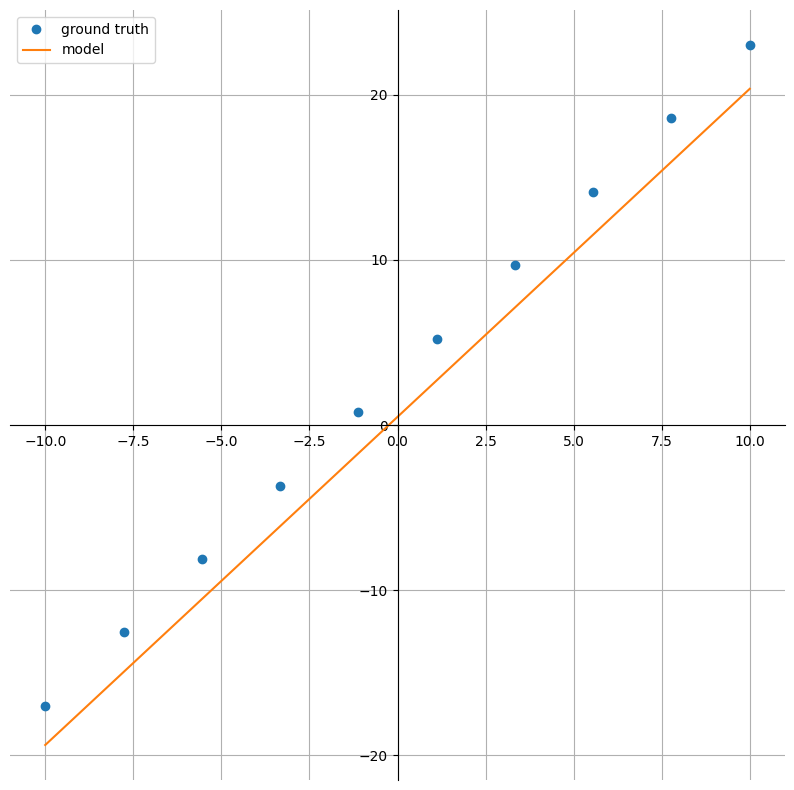

Epoch: 10; Train Loss: 6.064014911651611


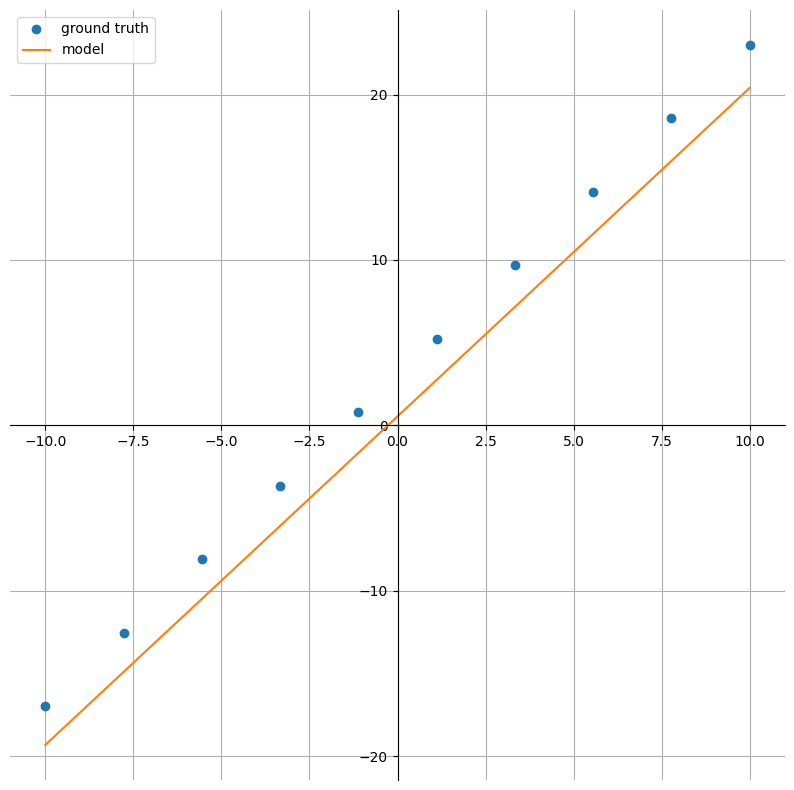

Epoch: 20; Train Loss: 5.826150417327881


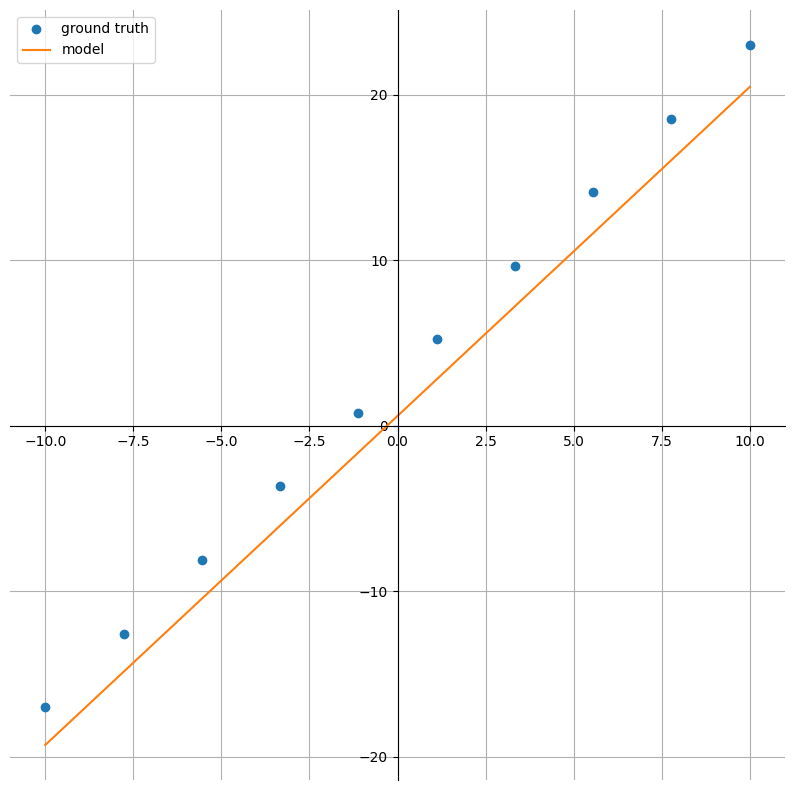

Epoch: 30; Train Loss: 5.597636699676514


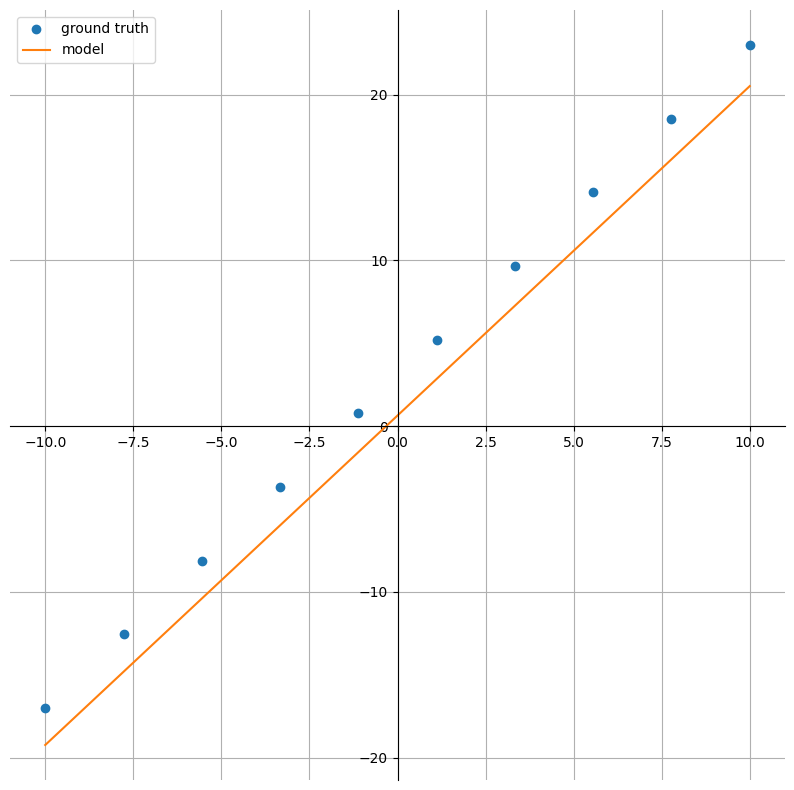

Epoch: 40; Train Loss: 5.378090858459473


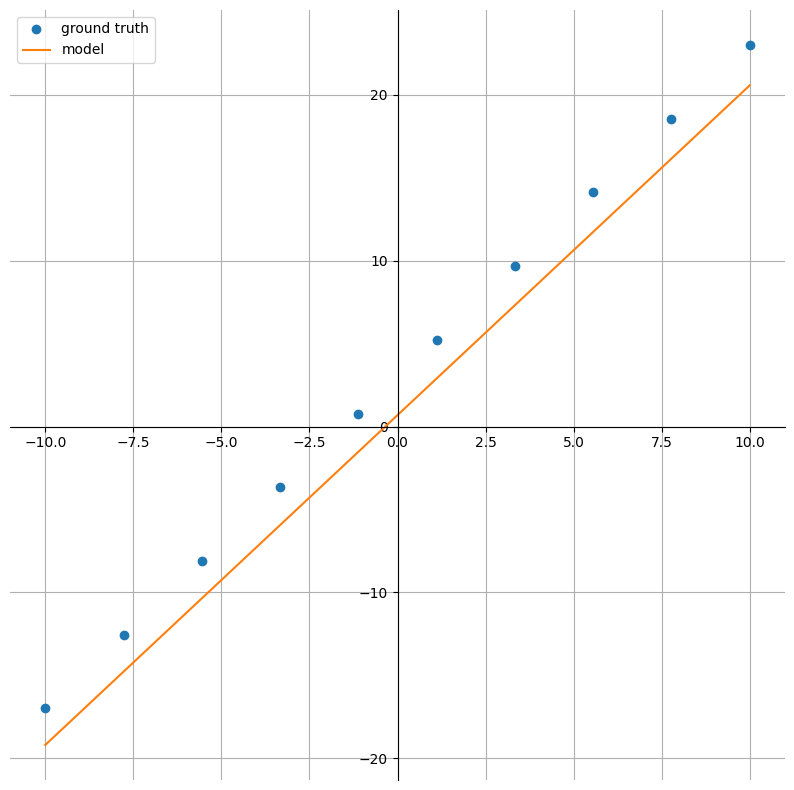

Epoch: 50; Train Loss: 5.16715669631958


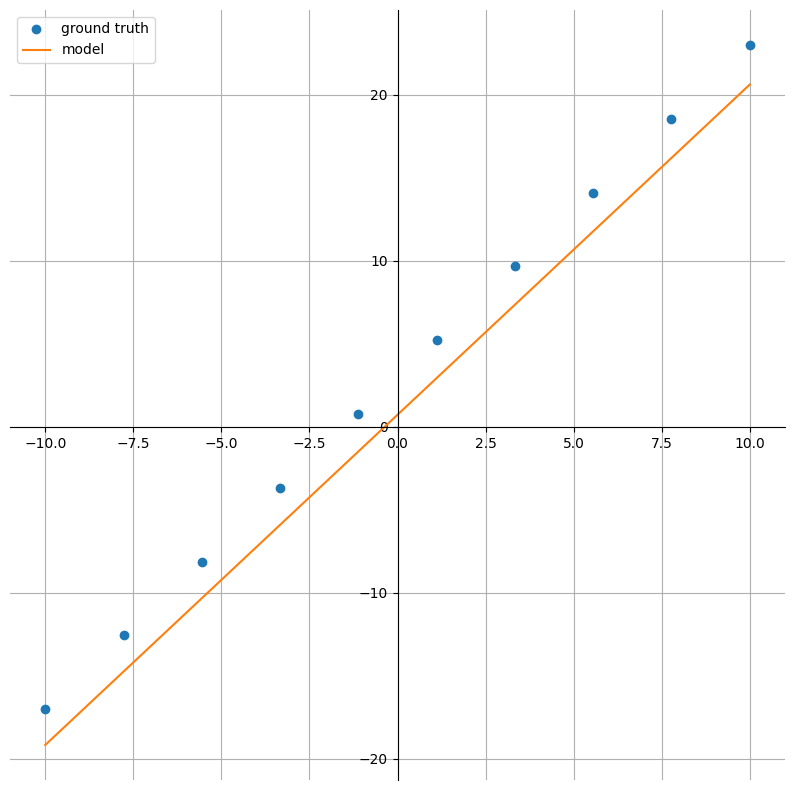

Epoch: 60; Train Loss: 4.964498043060303


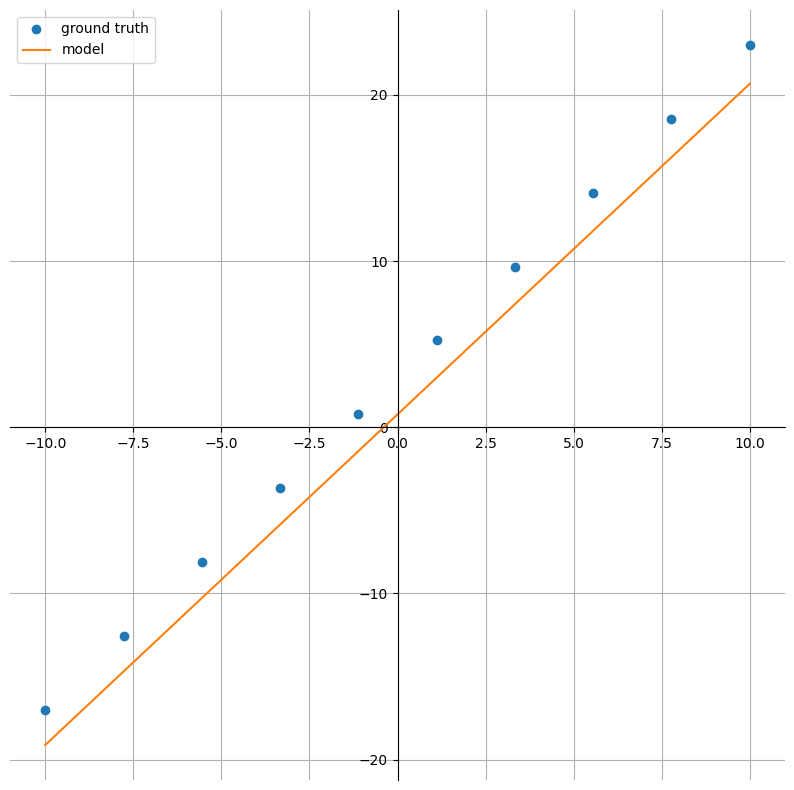

Epoch: 70; Train Loss: 4.7697858810424805


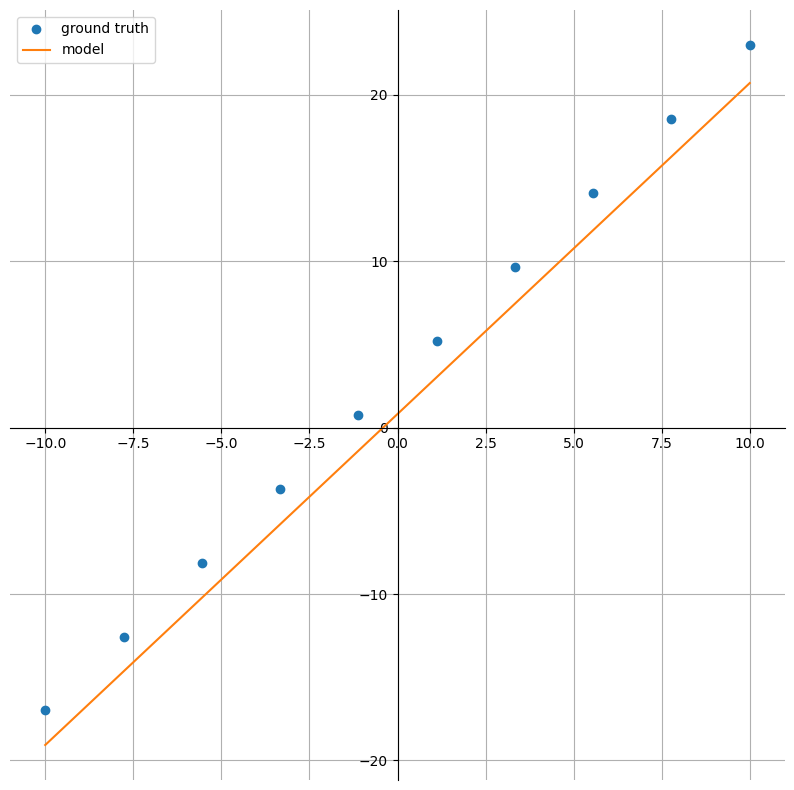

Epoch: 80; Train Loss: 4.5827107429504395


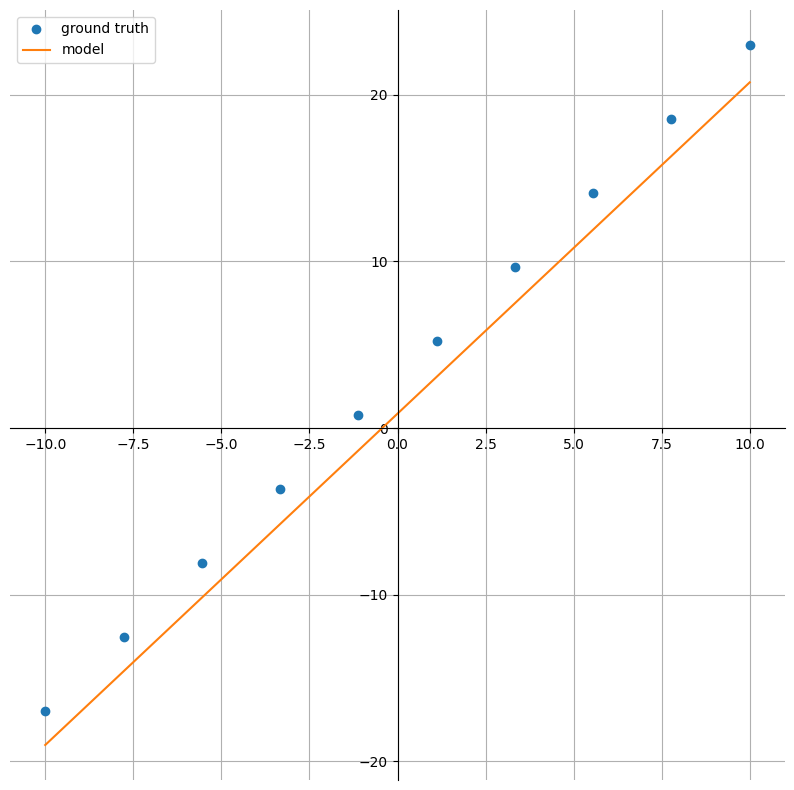

Epoch: 90; Train Loss: 4.402973651885986


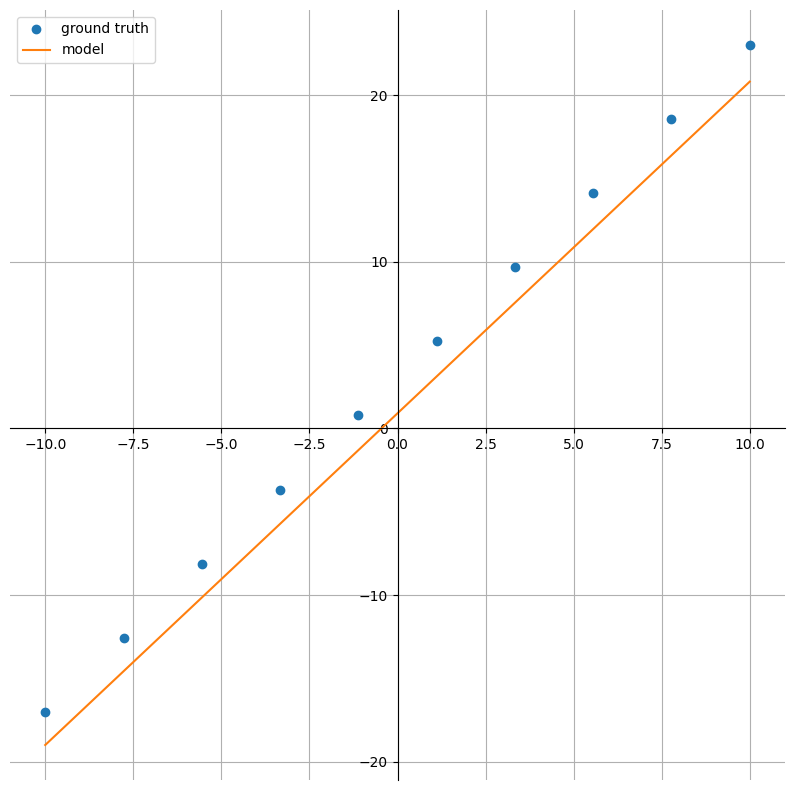

Epoch: 100; Train Loss: 4.23028564453125


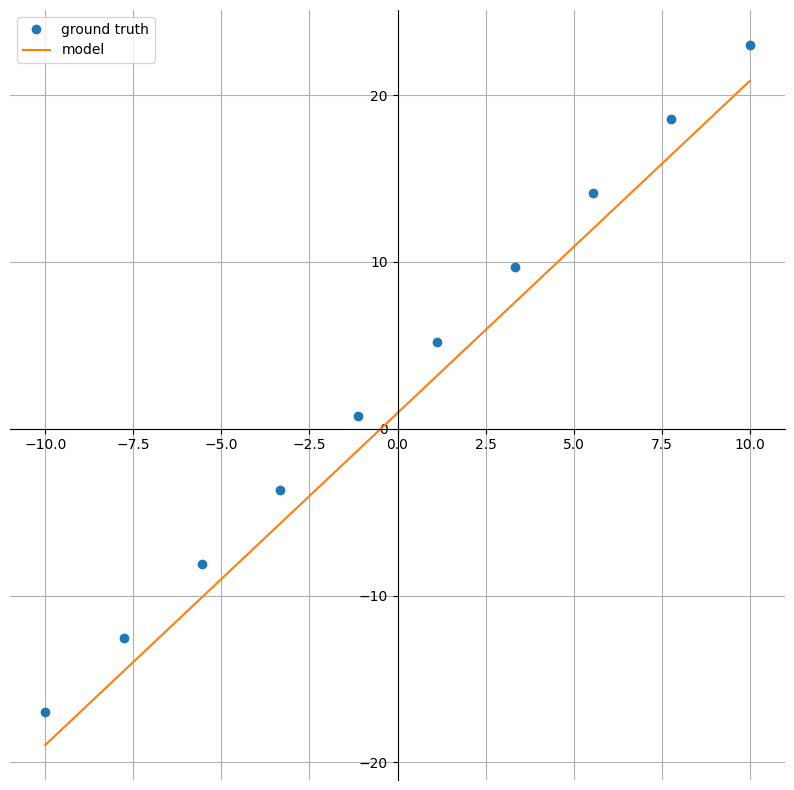

Test Loss: 4.238421440124512


In [28]:
epochs = 101
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")